# Met Office Climate Data Hackathon

_This notebook was originally written by Dr Fai Fung at the UK Met Office._
_His version is available at <https://github.com/COP26-Hackathon/Met-Office-Climate-Data-Challenge-March_2021>_

## Using xarray with UK Climate Projections data

This notebook shows you how to work with the UK Climate Projections netCDF files available on the CEDA Archive 
using the xarray Python library. It demonstrates:
 * how to read in a dataset
 * perform a few statistical tasks
  * calculate decadal means
  * calculate a simple spatial-averaging  
  * calculate monthly anomalies
 * how to create a simple and more advanced plots

This module requires the following:

*  Python packages in your environment 
 * xarray
 * numpy
 * cartopy


* UKCP data files
 * monthly mean surface air temperature (available from CEDA Archive [here](http://dap.ceda.ac.uk/badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/mon/latest/tas_rcp85_land-rcm_uk_12km_01_mon_198012-208011.nc))
 * land mask (available from [here](https://github.com/COP26-Hackathon/Met-Office-Climate-Data-Challenge-March_2021/blob/main/Wiki/assets/lsm_land-rcm_uk_12km.nc))
 * daily maximum surface air temperatures (available from CEDA Archive [here](http://data.ceda.ac.uk/badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tasmax/day/latest))

## Preparatory actions
Load `xarray` and other relevant packages

In [1]:
import numpy as np # Upgrade python to do array operations 
import xarray as xr # Let the numpy arrays support metadata and coordinates
import matplotlib.pyplot as plt # to allow plotting
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs # Cartopy allows us to add maps to the plots
import xarray_extras # This has some bonus xarray abilities, such as export to csv
%matplotlib inline

Assign file locations

In [2]:
# File of the monthly average surface temperatures from Dec 1980 to Nov 2080
UKCP_FILE = '~/UKCP18/mon/tas_rcp85_land-rcm_uk_12km_01_mon_198012-208011.nc'
# The land-sea mask used in the Met Office model
UKCP_FILE_LAND_MASK = '~/UKCP18/ukcp-other/land-sea_mask_uk_12km.nc'
# A directory containing all the daily maximum surface temperatures (must be stored in multiple files)
UKCP_FILE_DIRECTORY_TASMAX = '~/UKCP18/day'

 Load one or more netcdf data files into a dataset

In [3]:
# Load the data into a variable called dat
dat=xr.open_mfdataset(UKCP_FILE)

So what is in that dataset? Typing just `dat` on a line by itself will shows some information about it...

In [4]:
dat

<xarray.Dataset>
Dimensions:                       (bnds: 2, ensemble_member: 1, projection_x_coordinate: 82, projection_y_coordinate: 112, time: 1200)
Coordinates:
  * ensemble_member               (ensemble_member) int32 1
  * time                          (time) object 1980-12-16 00:00:00 ... 2080-...
  * projection_y_coordinate       (projection_y_coordinate) float64 -1.02e+05...
  * projection_x_coordinate       (projection_x_coordinate) float64 -2.1e+05 ...
    ensemble_member_id            (ensemble_member) |S27 dask.array<chunksize=(1,), meta=np.ndarray>
    grid_latitude                 (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(112, 82), meta=np.ndarray>
    grid_longitude                (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(112, 82), meta=np.ndarray>
    month_number                  (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    year                          (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    yyyymm                        (time) |S64 dask.array<chunksize=(1200,), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tas                           (ensemble_member, time, projection_y_coordinate, projection_x_coordinate) float32 dask.array<chunksize=(1, 1200, 112, 82), meta=np.ndarray>
    transverse_mercator           int32 ...
    time_bnds                     (time, bnds) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (projection_y_coordinate, bnds) float64 dask.array<chunksize=(112, 2), meta=np.ndarray>
    projection_x_coordinate_bnds  (projection_x_coordinate, bnds) float64 dask.array<chunksize=(82, 2), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-rcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-07-31T00:00
    domain:          uk
    frequency:       mon
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      12km
    scenario:        rcp85
    source:          UKCP18 regional realisation from a set of 12 limited-are...
    title:           UKCP18 land projections - 12km regional climate model, m...
    version:         v20190731
    Conventions:     CF-1.5

We can access several aspects of the dataset individually, by subsetting `dat` with a `.something` after it: 

In [5]:
print('dataset ',dat)
print('data variables ',dat.data_vars)
print('data values ',dat.values)
print('values of time axis ',dat.coords['time'].values)
print('year values of time axis ',dat.coords['time'].dt.year.values)

dataset  <xarray.Dataset>
Dimensions:                       (bnds: 2, ensemble_member: 1, projection_x_coordinate: 82, projection_y_coordinate: 112, time: 1200)
Coordinates:
  * ensemble_member               (ensemble_member) int32 1
  * time                          (time) object 1980-12-16 00:00:00 ... 2080-...
  * projection_y_coordinate       (projection_y_coordinate) float64 -1.02e+05...
  * projection_x_coordinate       (projection_x_coordinate) float64 -2.1e+05 ...
    ensemble_member_id            (ensemble_member) |S27 dask.array<chunksize=(1,), meta=np.ndarray>
    grid_latitude                 (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(112, 82), meta=np.ndarray>
    grid_longitude                (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(112, 82), meta=np.ndarray>
    month_number                  (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    year                          (time) int

We can select individual variabeles (called "data array" in xarray jargon).
We can store as a new variable `deca` then even print out the values if we want.

In [6]:
deca=dat.tas
print('values of data array ',deca.values)

values of data array  [[[[10.572838  10.57409   10.573993  ...  4.2704988  3.9337776
     3.7312722]
   [10.5091715 10.506336  10.500982  ...  4.0824256  3.857765
     3.689874 ]
   [10.45461   10.449013  10.441854  ...  3.9022734  3.7363775
     3.5822053]
   ...
   [ 5.554039   5.5632734  5.568901  ...  4.3970437  3.9209764
     2.9300287]
   [ 5.5127134  5.5592875  5.567969  ...  4.35584    3.8113449
     2.6090558]
   [ 5.505737   5.529365   5.5517626 ...  4.2395344  3.6436915
     2.4931693]]

  [[10.8545885 10.817315  10.789959  ...  5.3478227  5.095278
     4.953752 ]
   [10.800367  10.767013  10.740581  ...  5.194127   5.077076
     4.94965  ]
   [10.74936   10.707906  10.678672  ...  5.0930386  4.9980087
     4.8992662]
   ...
   [ 6.3170085  6.3096304  6.3096714 ...  6.0091066  5.8549833
     5.660276 ]
   [ 6.3050585  6.320441   6.3148546 ...  5.964722   5.8050027
     5.6040025]
   [ 6.233391   6.2660275  6.2974954 ...  5.9221044  5.7575097
     5.5582037]]

  [[10.851793  

## Resample data to decadal means
Climate varies becuase of the choatic nature of the atmospheric (both in reality and in climate models), so it's often helpful to average across several years. The Met Office likes to use 'meteorological' years, stretching from Dec-Nov - rather than Jan-Dec. Therefore all the files start in Dec of a year. The model also use some wonderful sleight-of-hand with the calendar. Each year is only 360 days, with 30 in each month. This makes it much easier for us to do computations. 

**Resample the array into only decadal means, with year starting 1st Dec**

In [7]:
deca3=deca.resample(time="10AS-DEC",).mean()      # works in vn 16 but not 11
print(deca3['time'])

<xarray.DataArray 'time' (time: 10)>
array([cftime.Datetime360Day(1980, 12, 1, 0, 0, 0, 0),
       cftime.Datetime360Day(1990, 12, 1, 0, 0, 0, 0),
       cftime.Datetime360Day(2000, 12, 1, 0, 0, 0, 0),
       cftime.Datetime360Day(2010, 12, 1, 0, 0, 0, 0),
       cftime.Datetime360Day(2020, 12, 1, 0, 0, 0, 0),
       cftime.Datetime360Day(2030, 12, 1, 0, 0, 0, 0),
       cftime.Datetime360Day(2040, 12, 1, 0, 0, 0, 0),
       cftime.Datetime360Day(2050, 12, 1, 0, 0, 0, 0),
       cftime.Datetime360Day(2060, 12, 1, 0, 0, 0, 0),
       cftime.Datetime360Day(2070, 12, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1980-12-01 00:00:00 ... 2070-12-01 00:00:00


**Produce a mean across spatial variables - to create a time series**

Note, this doesn't have area weighting. That is a common thing to do in climate datasets, and is needed to account for the fact that the Earth gets thinner as we move away from the Equator. However, this dataset is not provided using latitude and longitudes as their coordinates. It's already been reprojected onto the Ordance Survey's grid - so is in real distances, not angular ones.  

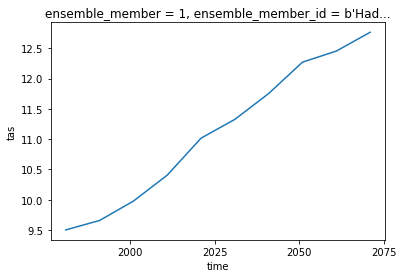

In [8]:
deca4=deca3.mean(dim=['projection_x_coordinate','projection_y_coordinate']).squeeze()
deca4.plot()

## Plot a smoothed time series of monthly means
The above time series - with only 8 data points doesn't look so good. Instead we could plot area average for every month (which will wiggle a lot), and then plot a smoothed one on top of it.

Create a running mean in deca5, plot then overplot higher frequency values from deca

/shared/groups/jrole001/geog0121/envs/jupyter_japsy/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


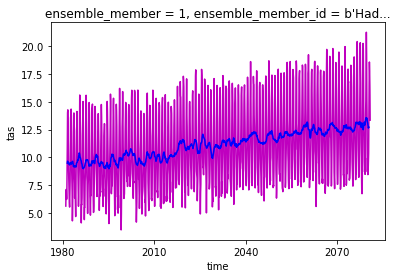

In [9]:
deca5=deca.rolling(time=12,center=True).mean()
deca.mean(dim=['projection_x_coordinate','projection_y_coordinate']).squeeze().plot(color='m')
deca5.mean(dim=['projection_x_coordinate','projection_y_coordinate']).squeeze().plot(color='b')

# Plot a map
Make a simple plot of the change in temperature seen over the 100 years. We'll go back to our decadal average temperatures. Let's look at its details

In [10]:
deca3

<xarray.DataArray 'tas' (ensemble_member: 1, time: 10, projection_y_coordinate: 112, projection_x_coordinate: 82)>
dask.array<transpose, shape=(1, 10, 112, 82), dtype=float32, chunksize=(1, 1, 112, 82), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) object 1980-12-01 00:00:00 ... 2070-12-01...
  * ensemble_member          (ensemble_member) int32 1
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.02e+05 ... ...
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.1e+05 ... 7...
    ensemble_member_id       (ensemble_member) |S27 dask.array<chunksize=(1,), meta=np.ndarray>
    grid_latitude            (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(112, 82), meta=np.ndarray>
    grid_longitude           (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(112, 82), meta=np.ndarray>

This shows the array's shape. This has 10 times (1 per decade). The (x,y) coordinates in the array, and the files in general are called (projection_y_coordinate, projection_x_coordinate) instead. There is also an degenerate dimension called "ensemble_member". For the hackathon, we are only providing a single model realisation. Ask us if you need to know more.

It also shows that its stored in 10 different 'chunks'. Don't worry about this - its to do with the way that `xarray` parallelises array structures.  

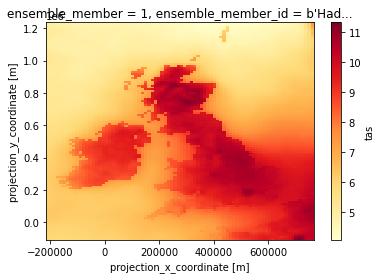

In [11]:
#diff=deca[0,9,:,:] # create a 2-D array and copy across the metadata
diff=deca[0,9,:,:]-deca[0,0,:,:]
diff.plot(cmap='YlOrRd')

**Apply a land/sea mask then plot**

Text(0.5, 1.0, 'first dataarray with land/sea mask applied')

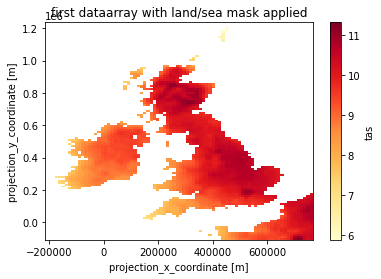

In [12]:
mask=xr.open_dataset(UKCP_FILE_LAND_MASK)
diff_lnd=diff.where(mask.lsm>0) #actually apply the land-sea mask (called lsm)
diff_lnd.plot(cmap='YlOrRd')
plt.title('first dataarray with land/sea mask applied')

**Make a nicer looking example plot of OSGB data on PlateCarree grid**

/shared/groups/jrole001/geog0121/envs/jupyter_japsy/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  


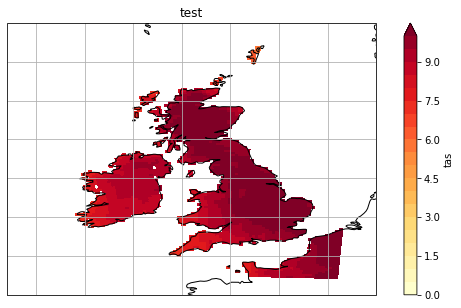

In [13]:
plt.figure(figsize=[10,5])
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.gridlines()

diff_lnd.plot(levels=np.linspace(0,10,21),cmap='YlOrRd',transform=ccrs.OSGB())
ax.set_title('test')
ax.set_extent([-14,5,48,62])

 **A slightly different plot with even more control over options**

/shared/groups/jrole001/geog0121/envs/jupyter_japsy/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  


Text(0.5, 1.0, 'Plot title here deg C \n')

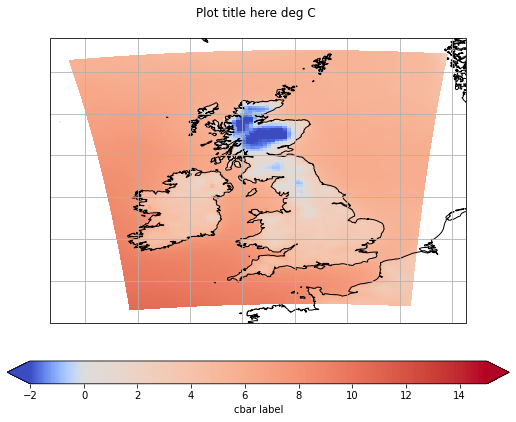

In [14]:
plt.figure(figsize=(10,7))
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

normplot=TwoSlopeNorm(vcenter=0,vmin=-2,vmax=15)
deca[0,0,:,:].plot.pcolormesh(ax=ax,norm=normplot,cmap='coolwarm',
                      transform=ccrs.OSGB(),extend='both',
                      cbar_kwargs=dict(orientation='horizontal',label='cbar label',shrink=0.9,pad=0.1))
ax.set_title('Plot title here deg C \n')

## Working with daily files
Load up some daily 'tasmax' data and select period to 2050. tasmax is the maximum surface temperature - it invariably happens in the middle of the afternoon.

In [15]:
path=UKCP_FILE_DIRECTORY_TASMAX
fi='/tasmax_*.nc'
tasmax_ds=xr.open_mfdataset(path+fi)
tasmax_da=tasmax_ds.tasmax.sel(time=slice('1980','2050'))
print(tasmax_ds)

<xarray.Dataset>
Dimensions:                       (bnds: 2, ensemble_member: 1, projection_x_coordinate: 82, projection_y_coordinate: 112, time: 36000)
Coordinates:
  * ensemble_member               (ensemble_member) int32 1
  * time                          (time) object 1980-12-01 12:00:00 ... 2080-...
  * projection_y_coordinate       (projection_y_coordinate) float64 -1.02e+05...
  * projection_x_coordinate       (projection_x_coordinate) float64 -2.1e+05 ...
    ensemble_member_id            (ensemble_member) |S27 dask.array<chunksize=(1,), meta=np.ndarray>
    grid_latitude                 (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(112, 82), meta=np.ndarray>
    grid_longitude                (projection_y_coordinate, projection_x_coordinate) float64 dask.array<chunksize=(112, 82), meta=np.ndarray>
    month_number                  (time) int32 dask.array<chunksize=(3600,), meta=np.ndarray>
    year                          (time) int32 dask.

Calculate monthly anomalies of tmax over region

In [16]:
climatology=tasmax_da.sel(time=slice('1981','2000')).groupby('time.month').mean().squeeze()
tasmax_anom=(tasmax_da.sel(time=slice('1981','2100')).groupby('time.month')-climatology).squeeze()

tasmax_anom_xymean=tasmax_anom.mean(dim=['projection_y_coordinate','projection_x_coordinate']).squeeze()
tasmax_anom_xymean_annual=tasmax_anom_xymean.resample(time='AS-DEC').mean()

In [17]:
climatology=tasmax_da.sel(time=slice('1981','2000')).groupby('time.month').mean().squeeze()
tasmax_mon=tasmax_da.sel(time=slice('1981','2100')).resample(time='M').mean().squeeze()
tasmax_anom=(tasmax_mon.groupby('time.month')-climatology).squeeze()

tasmax_anom_xymean=tasmax_anom.mean(dim=['projection_y_coordinate','projection_x_coordinate']).squeeze()
tasmax_anom_xymean_annual=tasmax_anom_xymean.resample(time='AS-DEC').mean()

Let's also compare with absolute values of monthly mean tmax across region

In [18]:
tasmax_annual=tasmax_da.sel(time=slice('1981','2100')).mean(dim=['projection_y_coordinate',
                                'projection_x_coordinate']).resample(time='M').mean().squeeze()

Now plot the results

(-5.0, 25.0)

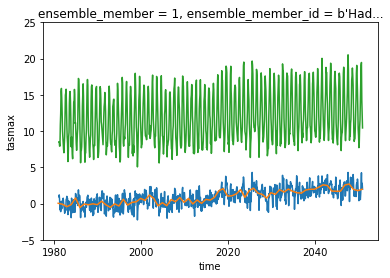

In [19]:
tasmax_anom_xymean.plot()              # monthly anomalies  
tasmax_anom_xymean_annual.plot()       # annual mean of anomalies
tasmax_annual.plot()                   # absolute values
plt.ylim([-5,25])